In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [14]:
!pip3 install pandas


[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [3]:
from dataloader import create_gw_loaders
import dataloader

In [8]:
!pip3 install tqdm

  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)

[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [3]:
!python3 dataloader.py

/opt/homebrew/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Figure(640x480)
<class 'str'>
Figure(640x480)
<class 'str'>
Figure(640x480)
<class 'str'>
Figure(640x480)
<class 'str'>
Figure(640x480)
<class 'str'>
Figure(640x480)
<class 'str'>
/opt/homebrew/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The

In [10]:
!pip3 install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 2.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


# END of imports. Code starts

In [4]:
labels = [chr(ord('A') + i) for i in range(26)] + [chr(ord('a') + i) for i in range(26)] + [str(i) for i in range(10)]
print(labels)
def one_hot_encode(x):
    return torch.FloatTensor([int(i == x) for i in labels])
print(one_hot_encode('5'))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0.])


In [5]:
latent_dims = 10
num_epochs = 100
batch_size = 10
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True
node_size = 500 #as in the article


subset = ['a', 'b', 'A', '3']
subset_size = len(subset) #number of letters in the subset

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, node_size)
        self.fc2 = nn.Linear(node_size, node_size)
        self.fc3 = nn.Linear(node_size, node_size)
                
        self.fc_mu = nn.Linear(in_features=node_size, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=node_size, out_features=latent_dims)

    def forward(self, x):        
        x = x[0]
        x = torch.reshape(x, (-1,))
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        print(x.shape)
        x = torch.reshape(x, (1,500))
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims + len(labels), out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x, label):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        label_enc = torch.tensor(np.stack([one_hot_encode(label) for _ in range(latent.shape[0])]))
#         print(label_enc.shape, latent.shape) # (10, 62)    (10, 2)
        x_recon = self.decoder(torch.hstack((latent, label_enc)))
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence


vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 1493537


In [10]:
train_loader, test_loader = create_gw_loaders()
k = 0
for image_batch_, label in train_loader:
    k+=1
    if k > 1:
        break
    tns = image_batch[6]
    print(tns.shape)
    plt.imshow(tns.permute(1, 2, 0))

/usr/local/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


NameError: name 'image_batch' is not defined

In [8]:
import tqdm
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()
train_loader, test_loader = create_gw_loaders()

train_loss_avg = []

print('Training ...')
for epoch in tqdm.tqdm(range(num_epochs)):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch_, label in train_loader:
        for (image_batch, l) in zip(image_batch_, label):
#             print(l)
#             print(image_batch.shape)

            image_batch = image_batch.to(device)

            # vae reconstruction
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch, l)

            # reconstruction error
            loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()

            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()

            train_loss_avg[-1] += loss.item()
            num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...


  0%|                                                   | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|                                                   | 0/100 [00:00<?, ?it/s]

torch.Size([500, 1])


ValueError: Using a target size (torch.Size([10, 784])) that is different to the input size (torch.Size([1, 784])) is deprecated. Please ensure they have the same size.

In [ ]:
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch_, label in test_loader:
    for (image_batch, l) in zip(image_batch_, label):
        with torch.no_grad():

            image_batch = image_batch.to(device)

            # vae reconstruction
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch, l)

            # reconstruction error
            loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

            test_loss_avg += loss.item()
            num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

In [12]:
train_loader, test_loader = create_gw_loaders()

In [13]:
for image_batch_, label in test_loader:
    print(image_batch_.shape)
    g = image_batch[0]
    print(g.shape)

torch.Size([4, 10, 1, 28, 28])


NameError: name 'image_batch' is not defined

torch.Size([1, 1, 28, 28])


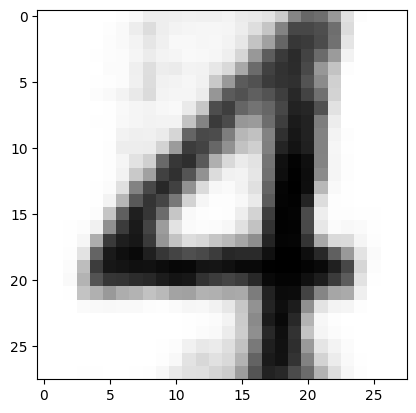

torch.Size([1, 1, 28, 28])


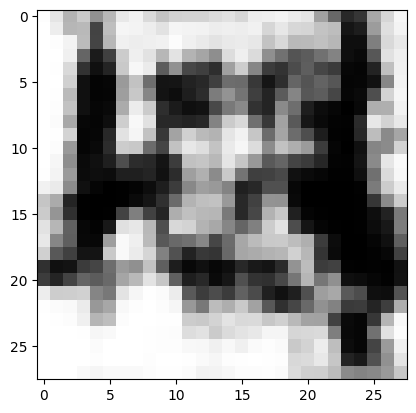

torch.Size([1, 1, 28, 28])


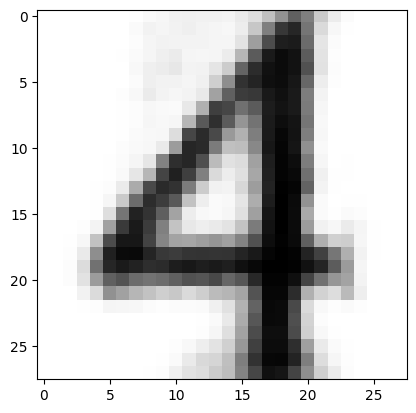

torch.Size([1, 1, 28, 28])


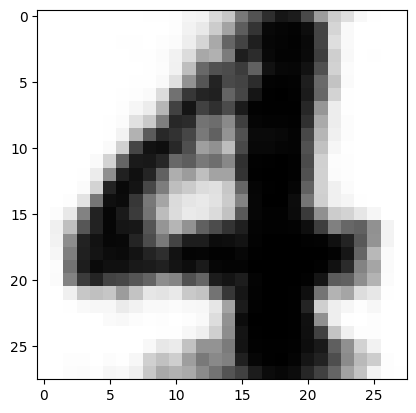

torch.Size([1, 1, 28, 28])


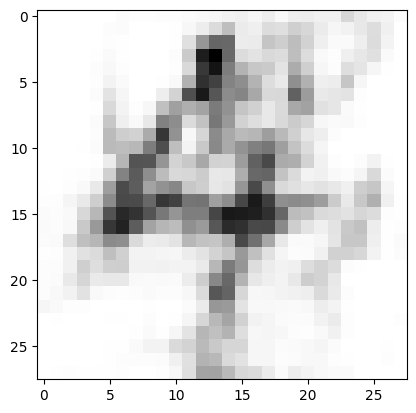

torch.Size([1, 1, 28, 28])


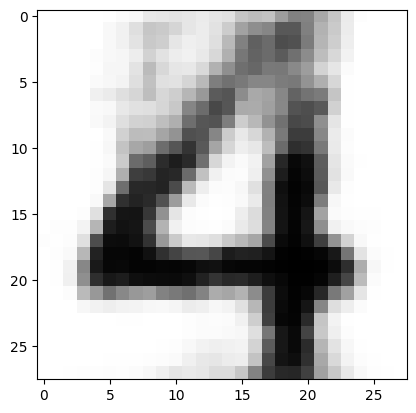

torch.Size([1, 1, 28, 28])


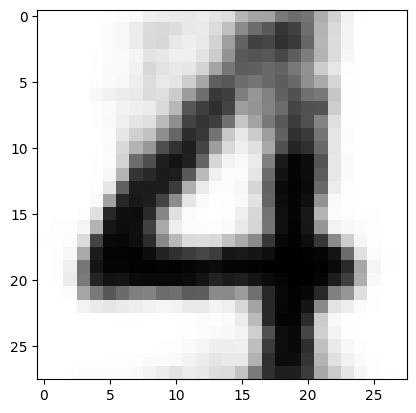

torch.Size([1, 1, 28, 28])


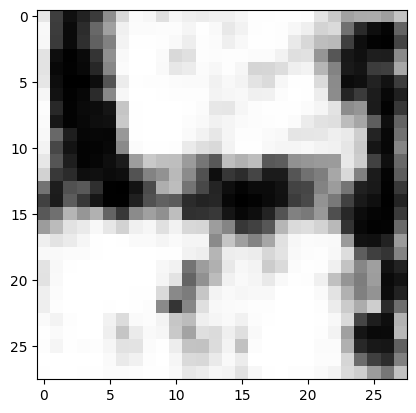

torch.Size([1, 1, 28, 28])


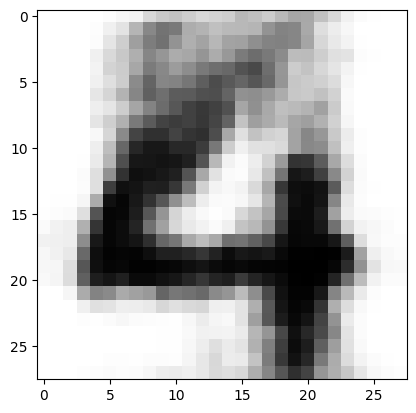

torch.Size([1, 1, 28, 28])


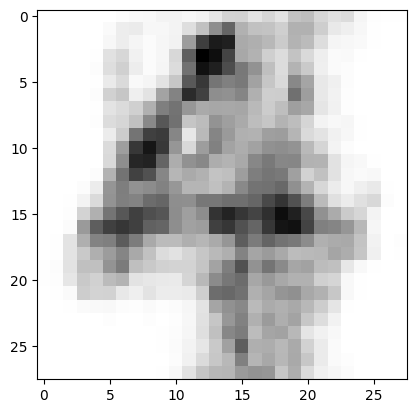

torch.Size([1, 1, 28, 28])


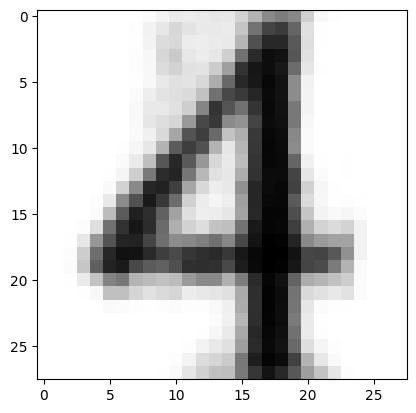

torch.Size([1, 1, 28, 28])


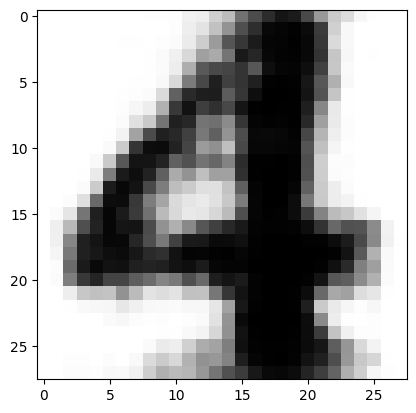

torch.Size([1, 1, 28, 28])


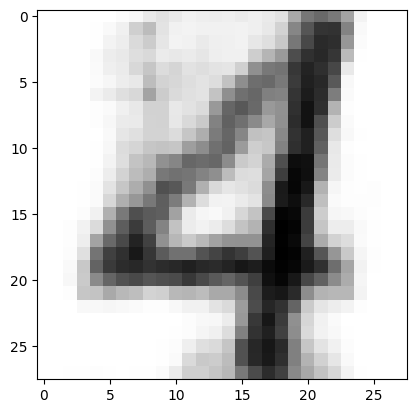

torch.Size([1, 1, 28, 28])


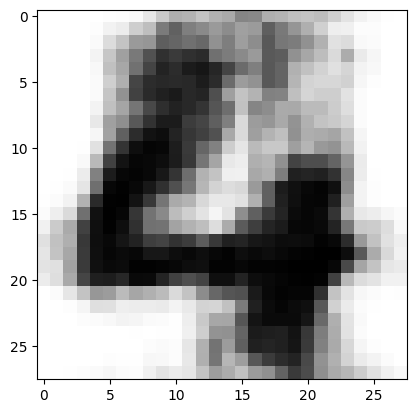

torch.Size([1, 1, 28, 28])


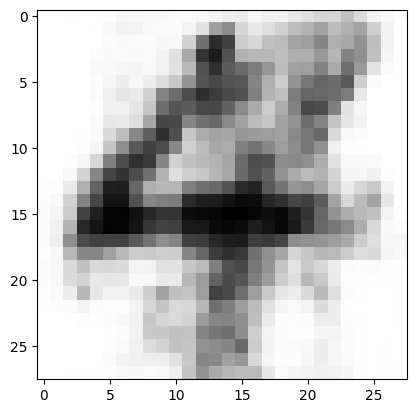

torch.Size([1, 1, 28, 28])


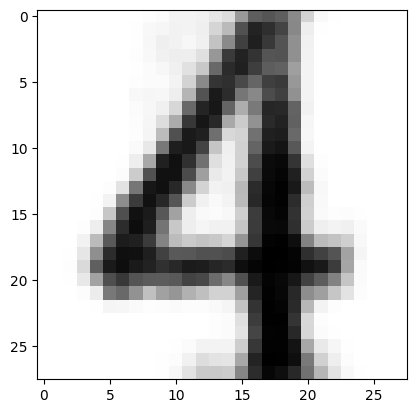

torch.Size([1, 1, 28, 28])


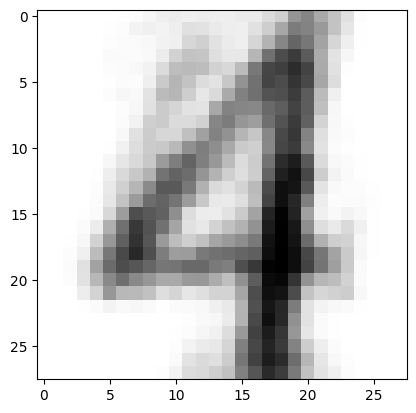

torch.Size([1, 1, 28, 28])


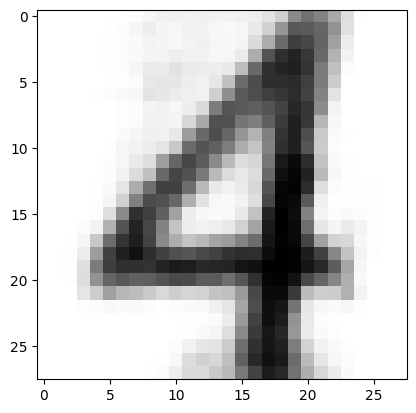

torch.Size([1, 1, 28, 28])


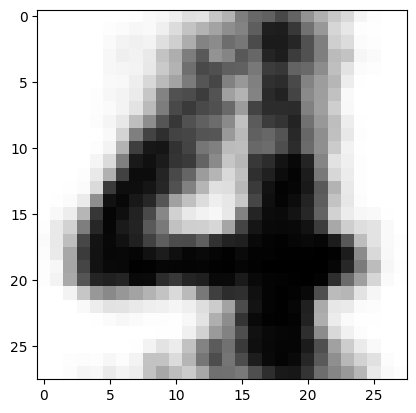

torch.Size([1, 1, 28, 28])


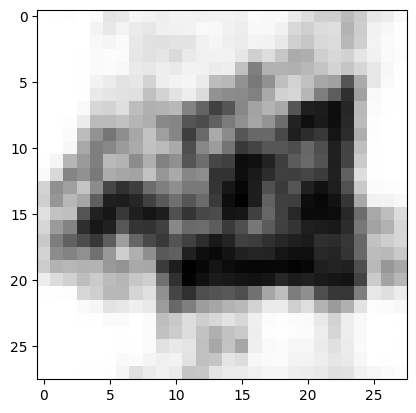

torch.Size([1, 1, 28, 28])


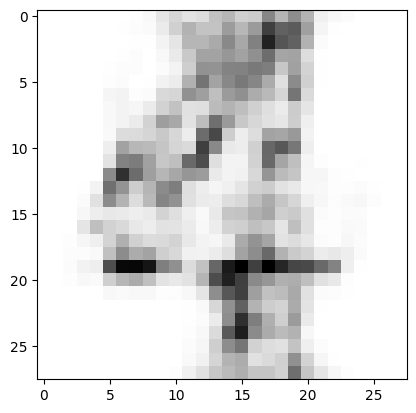

torch.Size([1, 1, 28, 28])


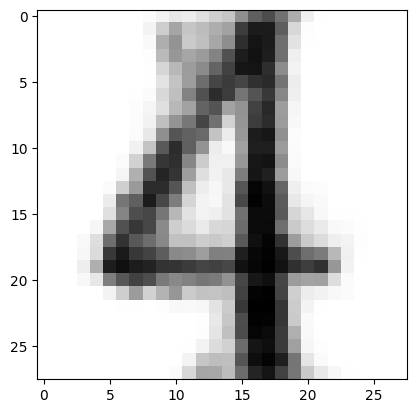

torch.Size([1, 1, 28, 28])


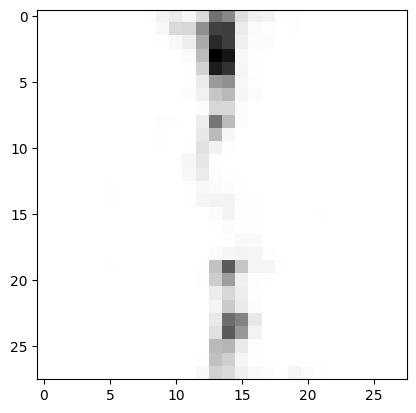

torch.Size([1, 1, 28, 28])


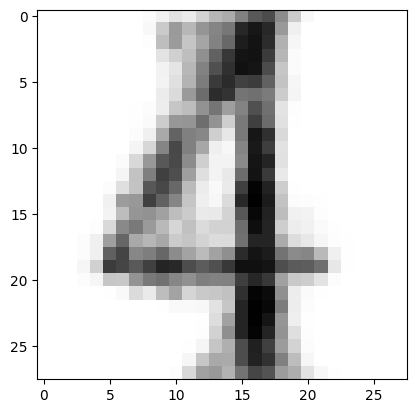

torch.Size([1, 1, 28, 28])


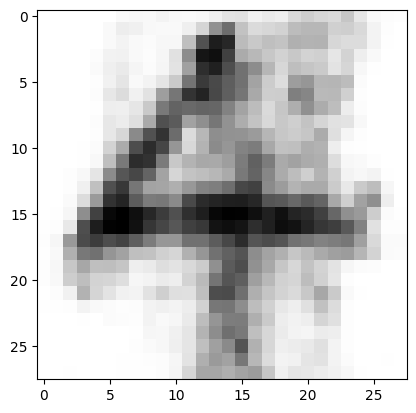

torch.Size([1, 1, 28, 28])


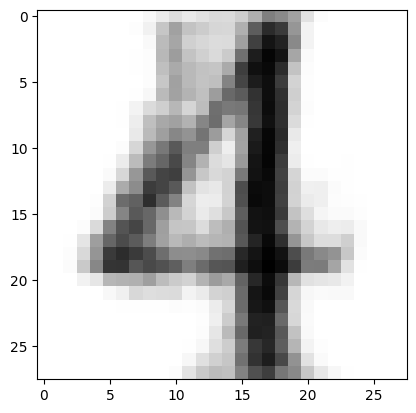

torch.Size([1, 1, 28, 28])


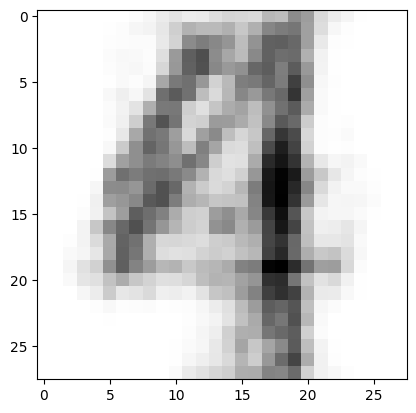

torch.Size([1, 1, 28, 28])


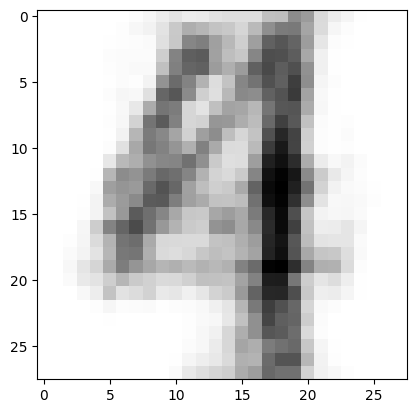

torch.Size([1, 1, 28, 28])


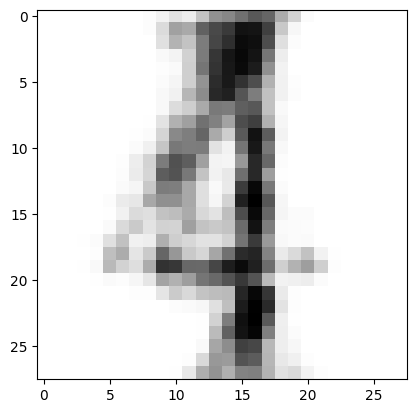

torch.Size([1, 1, 28, 28])


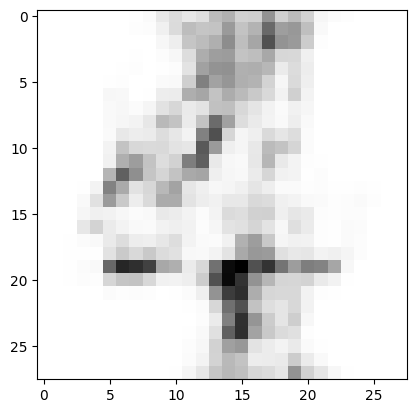

torch.Size([1, 1, 28, 28])


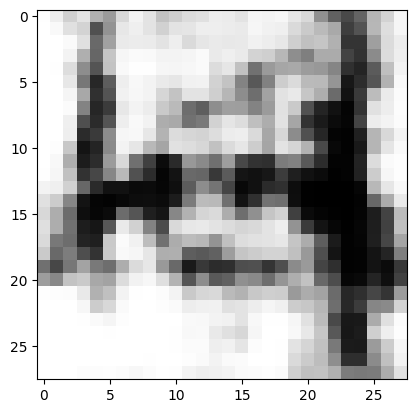

torch.Size([1, 1, 28, 28])


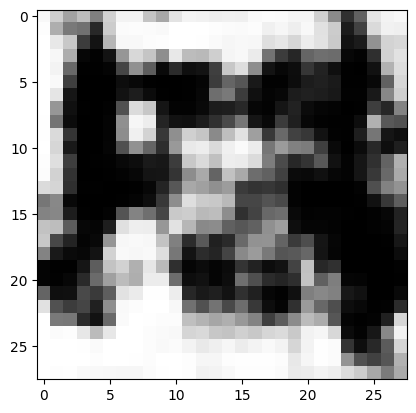

torch.Size([1, 1, 28, 28])


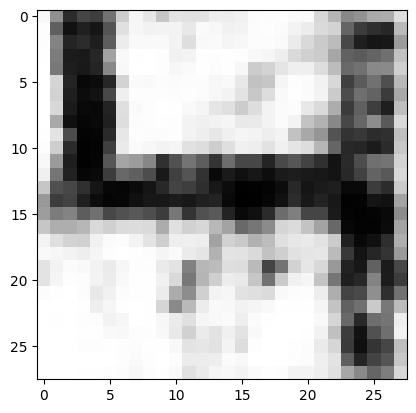

torch.Size([1, 1, 28, 28])


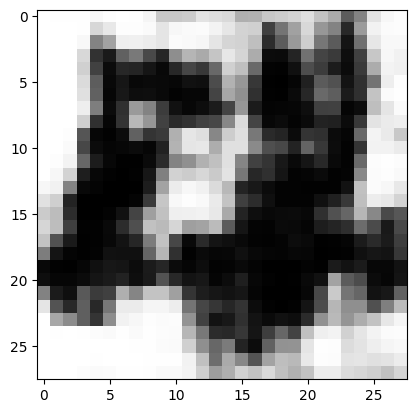

torch.Size([1, 1, 28, 28])


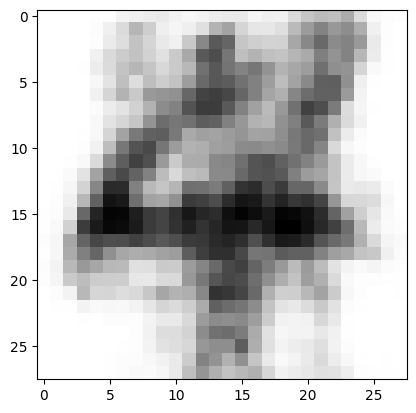

torch.Size([1, 1, 28, 28])


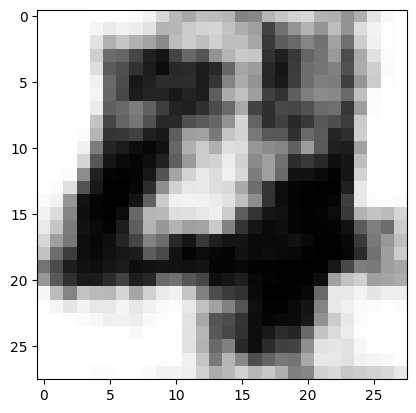

torch.Size([1, 1, 28, 28])


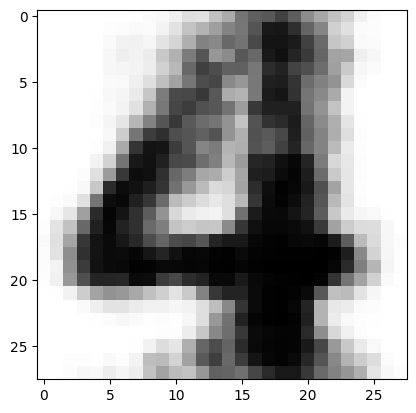

torch.Size([1, 1, 28, 28])


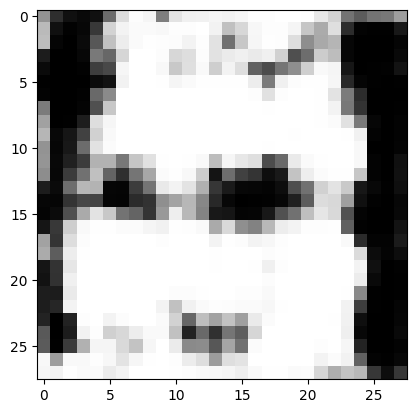

torch.Size([1, 1, 28, 28])


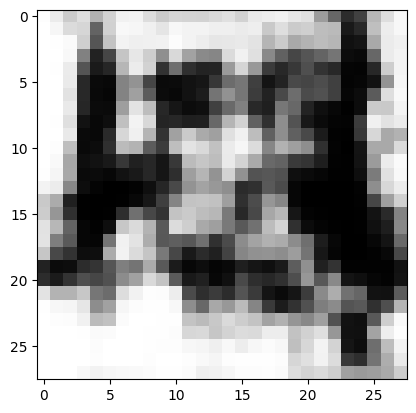

torch.Size([1, 1, 28, 28])


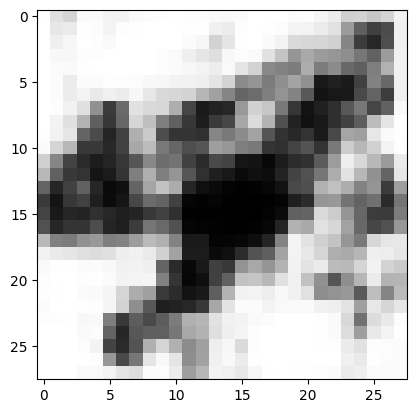

torch.Size([1, 1, 28, 28])


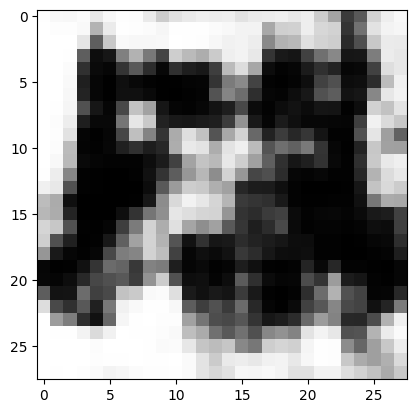

torch.Size([1, 1, 28, 28])


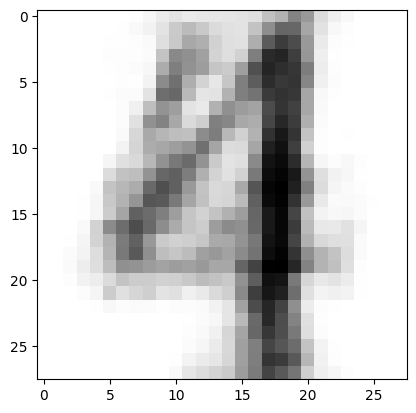

torch.Size([1, 1, 28, 28])


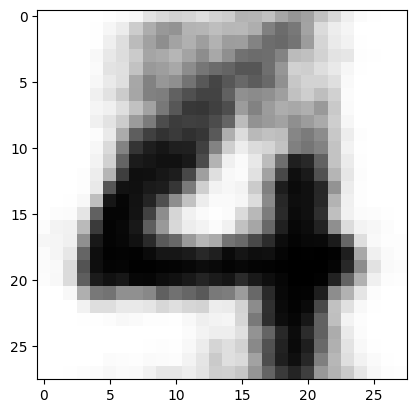

torch.Size([1, 1, 28, 28])


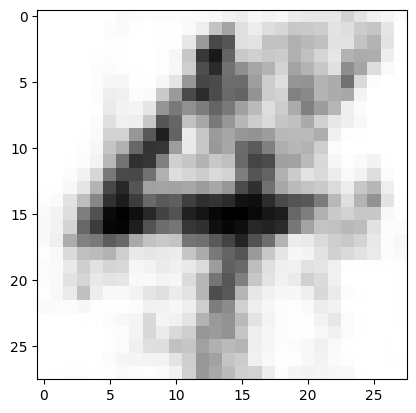

torch.Size([1, 1, 28, 28])


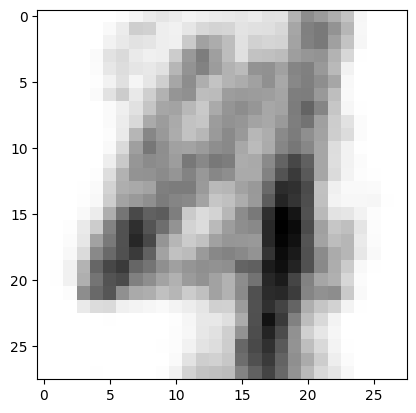

torch.Size([1, 1, 28, 28])


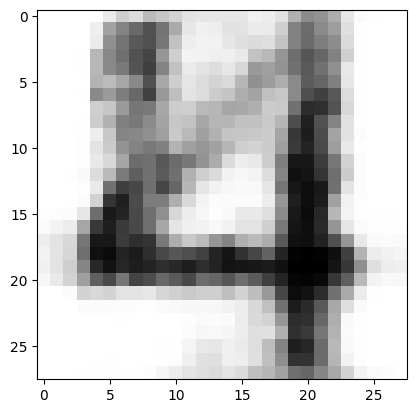

torch.Size([1, 1, 28, 28])


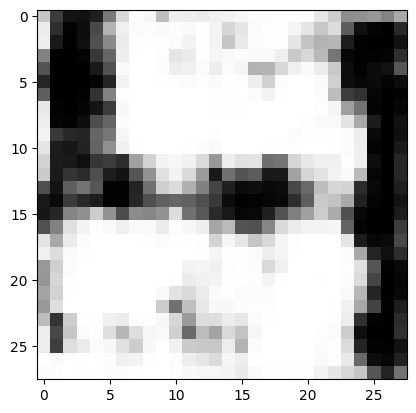

torch.Size([1, 1, 28, 28])


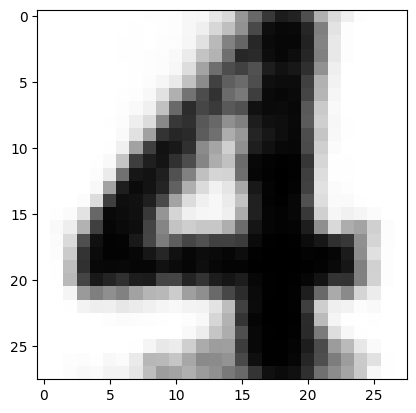

torch.Size([1, 1, 28, 28])


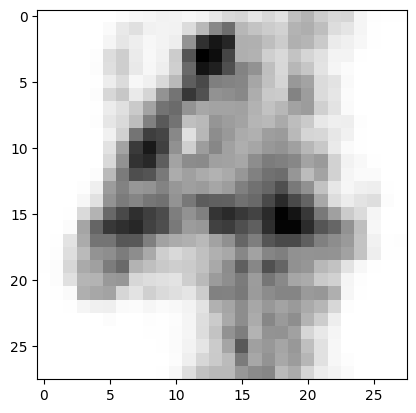

torch.Size([1, 1, 28, 28])


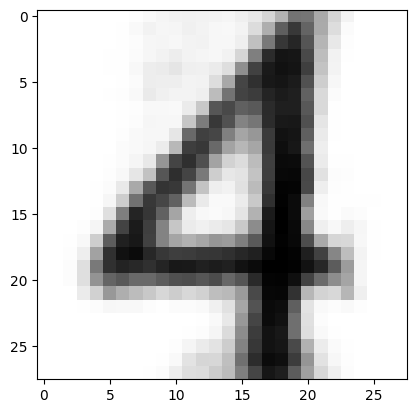

torch.Size([1, 1, 28, 28])


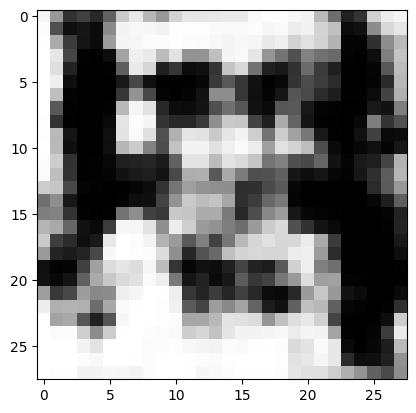

torch.Size([1, 1, 28, 28])


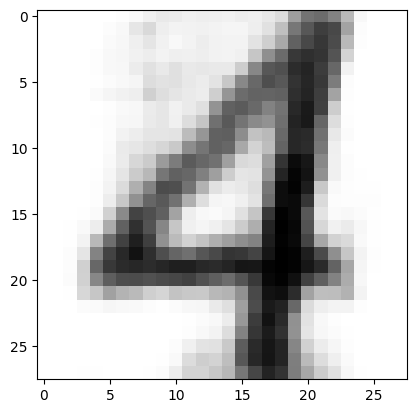

torch.Size([1, 1, 28, 28])


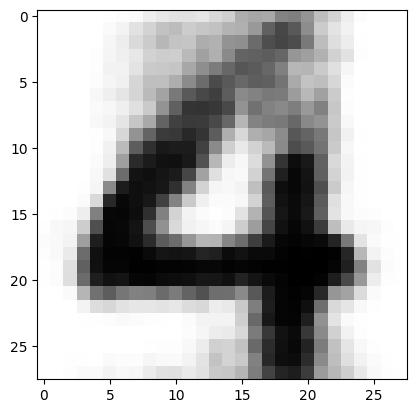

torch.Size([1, 1, 28, 28])


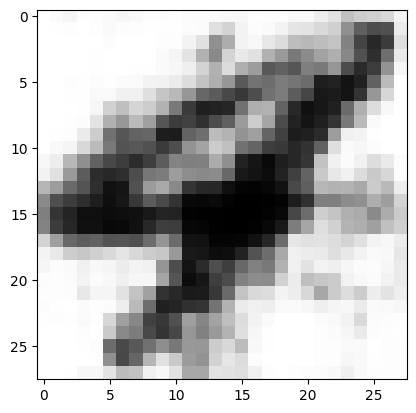

torch.Size([1, 1, 28, 28])


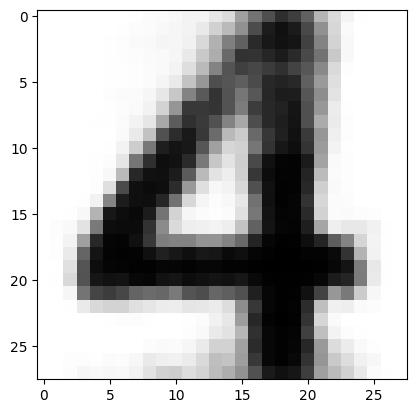

torch.Size([1, 1, 28, 28])


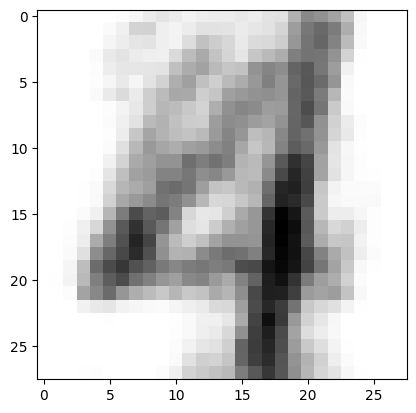

torch.Size([1, 1, 28, 28])


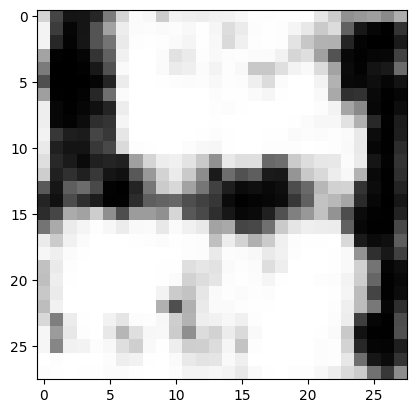

torch.Size([1, 1, 28, 28])


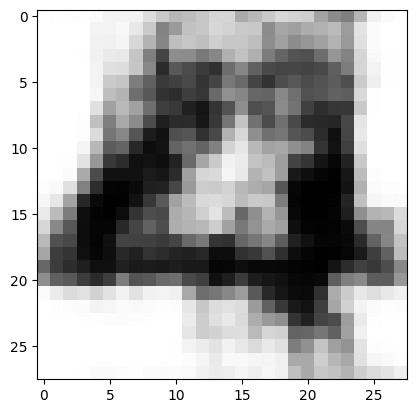

torch.Size([1, 1, 28, 28])


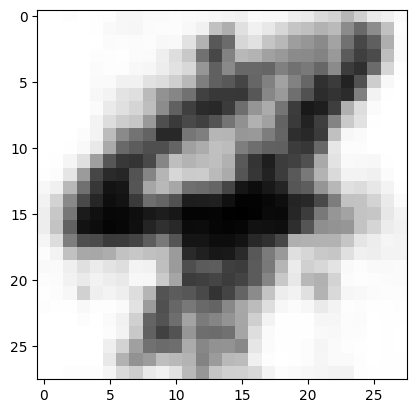

torch.Size([1, 1, 28, 28])


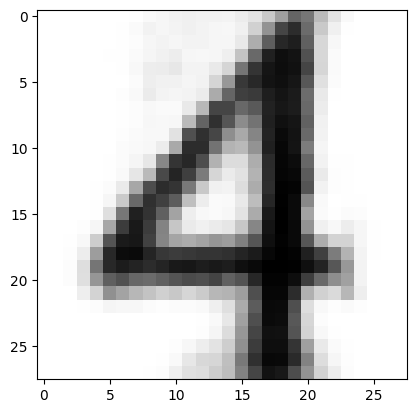

torch.Size([1, 1, 28, 28])


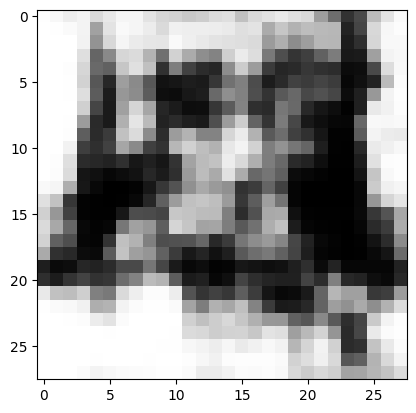

torch.Size([1, 1, 28, 28])


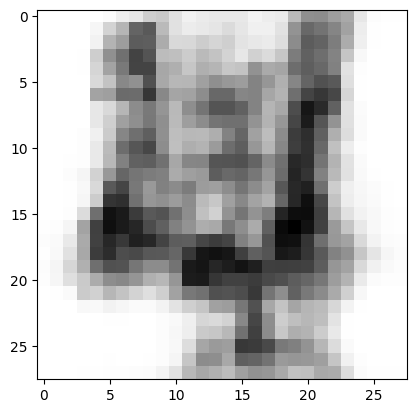

torch.Size([1, 1, 28, 28])


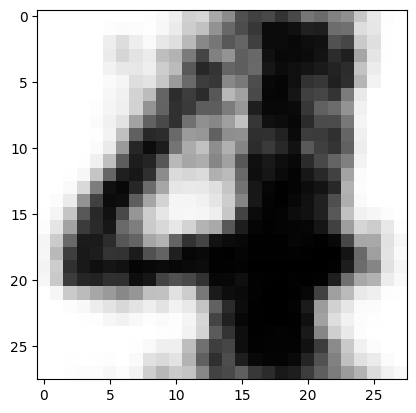

torch.Size([1, 1, 28, 28])


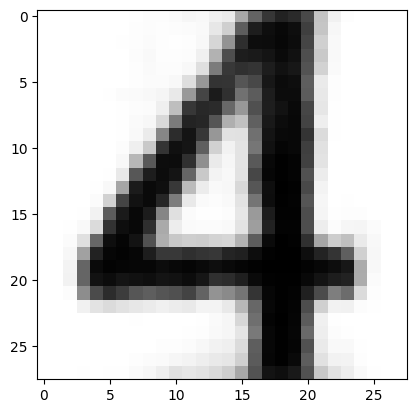

torch.Size([1, 1, 28, 28])


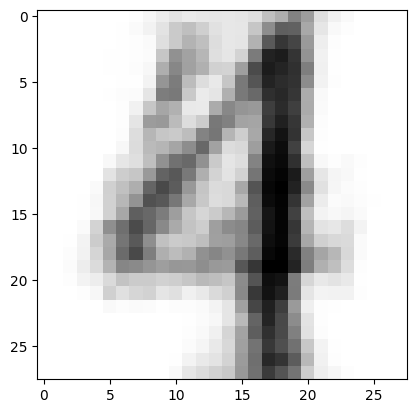

torch.Size([1, 1, 28, 28])


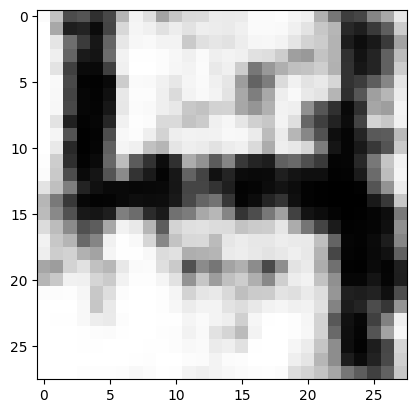

torch.Size([1, 1, 28, 28])


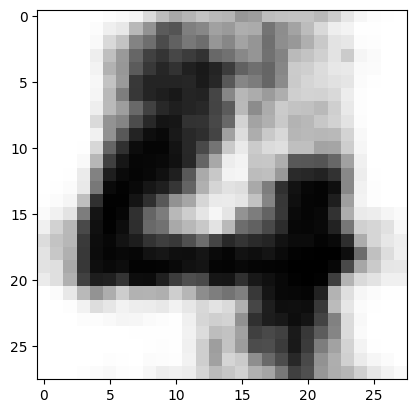

torch.Size([1, 1, 28, 28])


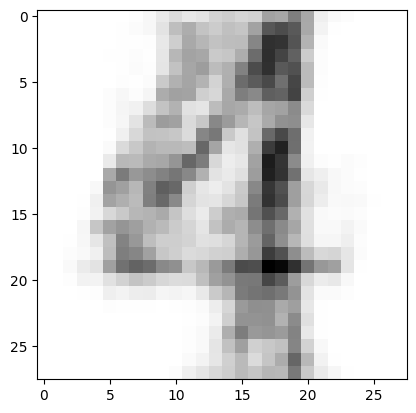

torch.Size([1, 1, 28, 28])


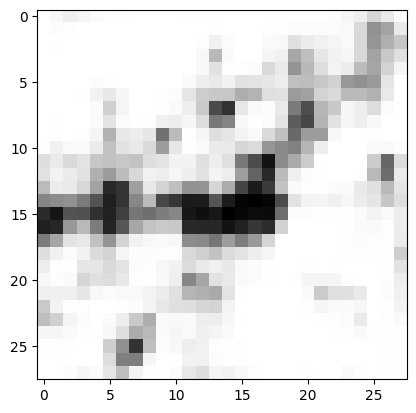

torch.Size([1, 1, 28, 28])


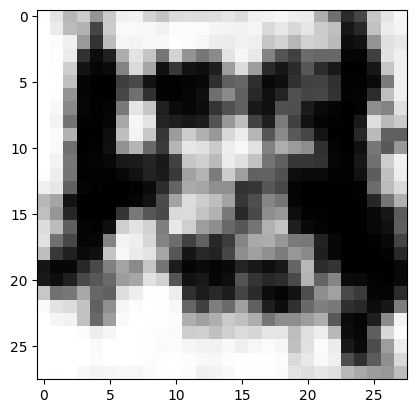

torch.Size([1, 1, 28, 28])


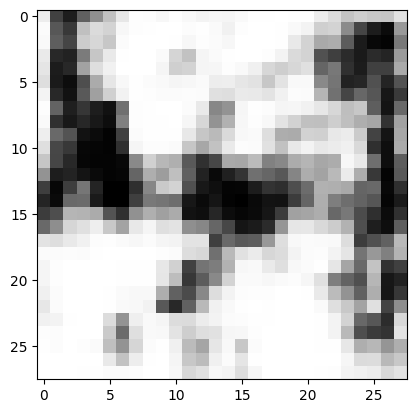

torch.Size([1, 1, 28, 28])


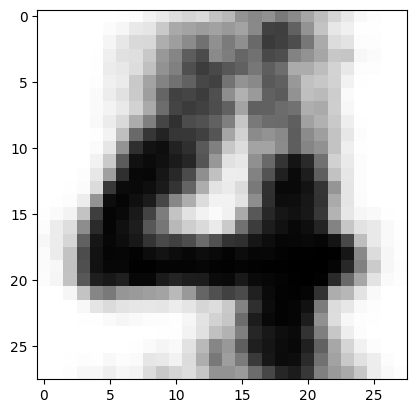

torch.Size([1, 1, 28, 28])


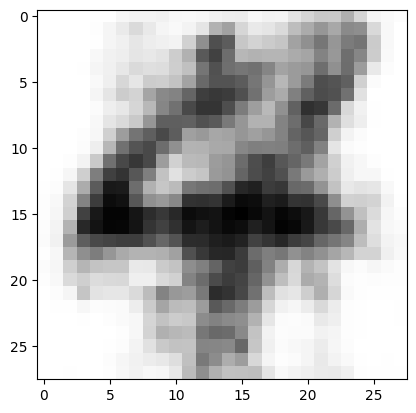

torch.Size([1, 1, 28, 28])


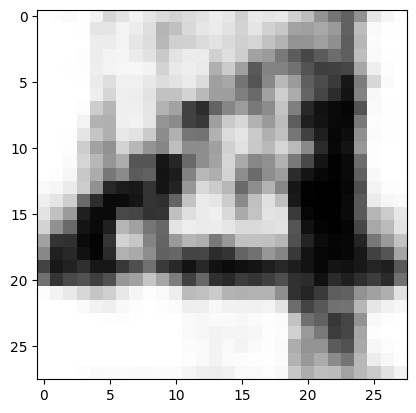

torch.Size([1, 1, 28, 28])


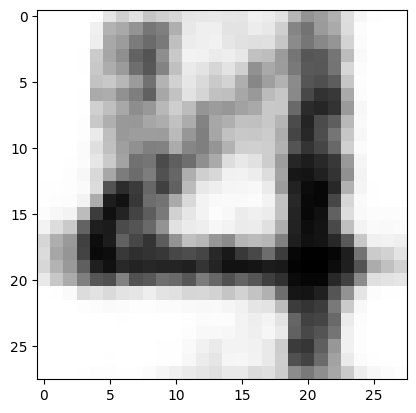

torch.Size([1, 1, 28, 28])


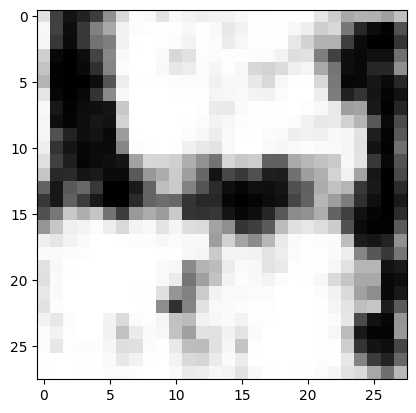

torch.Size([1, 1, 28, 28])


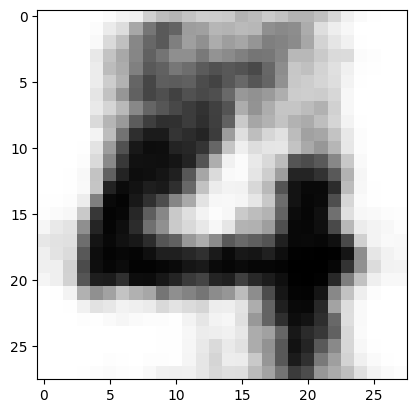

torch.Size([1, 1, 28, 28])


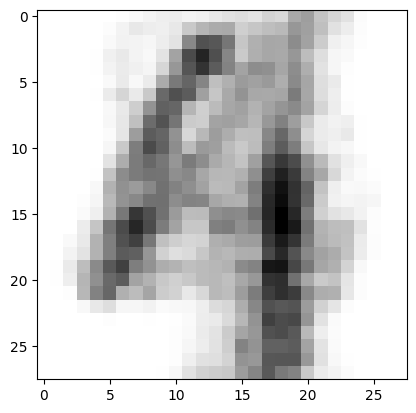

torch.Size([1, 1, 28, 28])


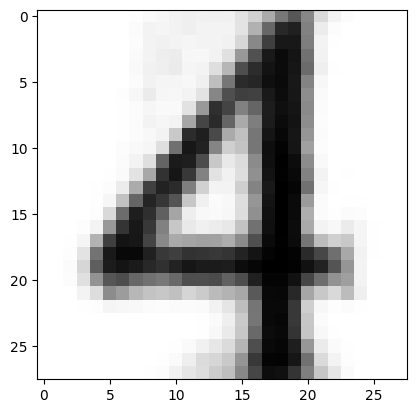

torch.Size([1, 1, 28, 28])


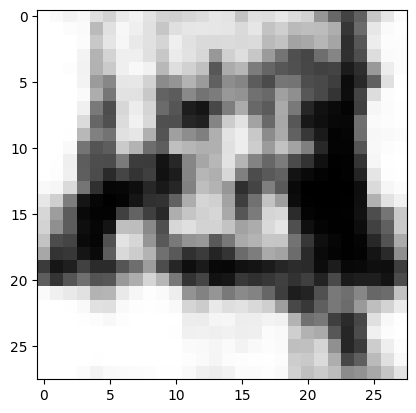

torch.Size([1, 1, 28, 28])


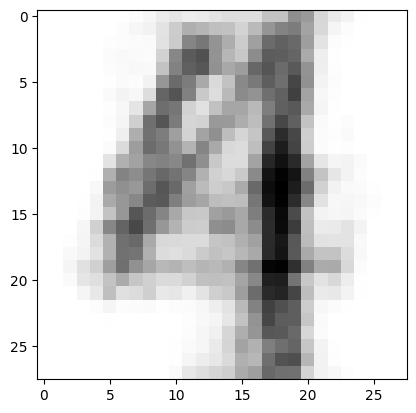

torch.Size([1, 1, 28, 28])


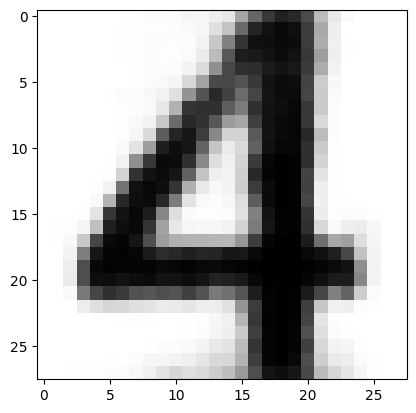

torch.Size([1, 1, 28, 28])


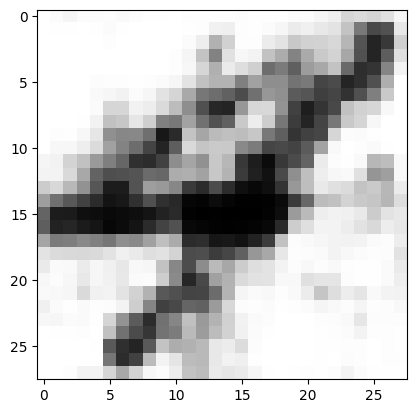

torch.Size([1, 1, 28, 28])


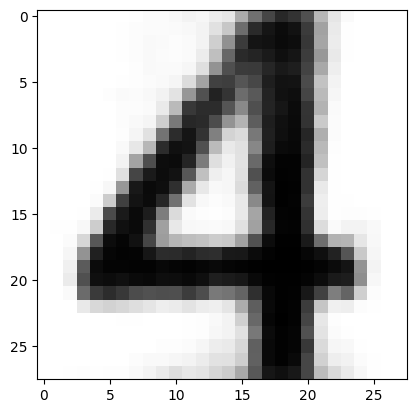

torch.Size([1, 1, 28, 28])


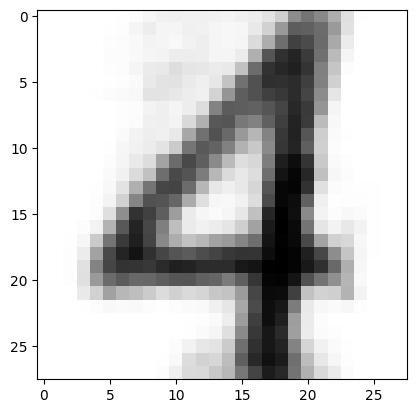

torch.Size([1, 1, 28, 28])


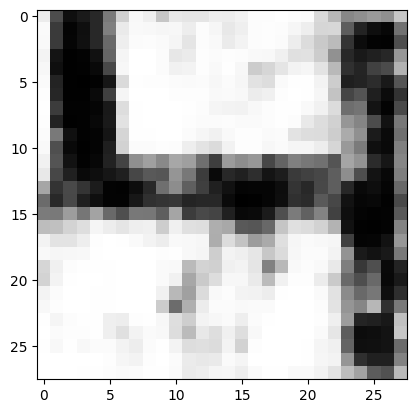

torch.Size([1, 1, 28, 28])


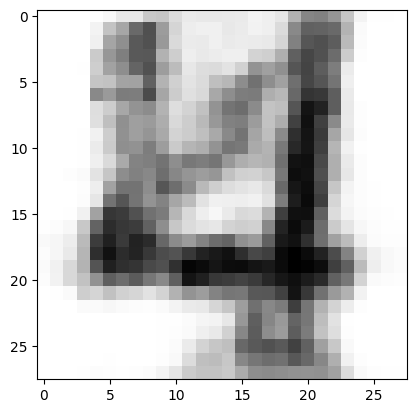

torch.Size([1, 1, 28, 28])


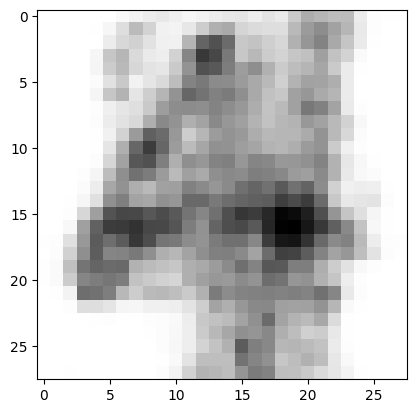

torch.Size([1, 1, 28, 28])


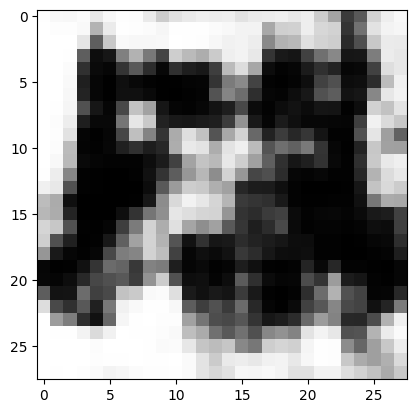

torch.Size([1, 1, 28, 28])


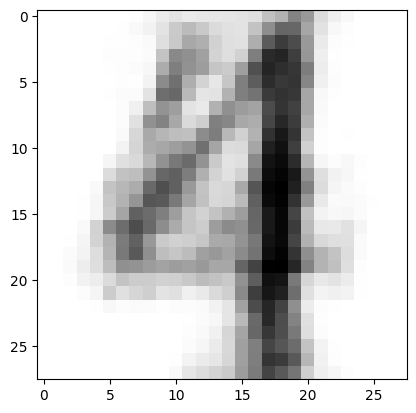

torch.Size([1, 1, 28, 28])


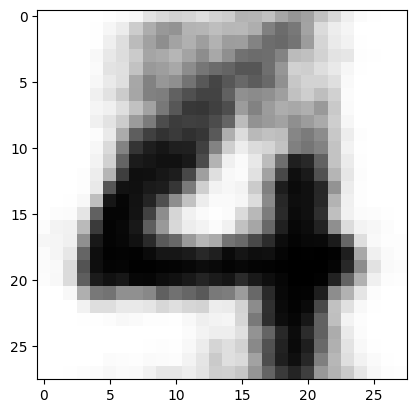

torch.Size([1, 1, 28, 28])


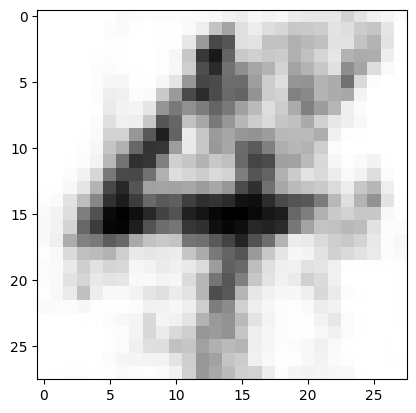

torch.Size([1, 1, 28, 28])


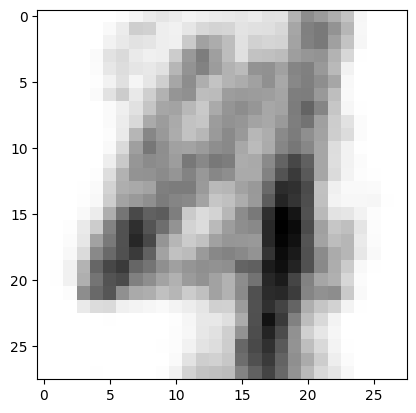

torch.Size([1, 1, 28, 28])


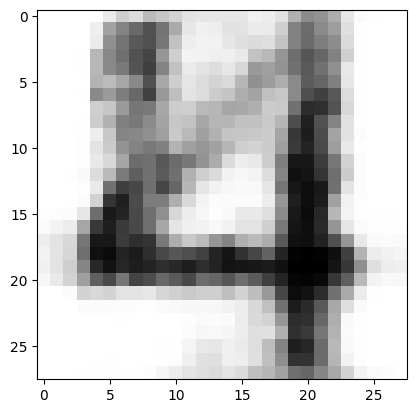

torch.Size([1, 1, 28, 28])


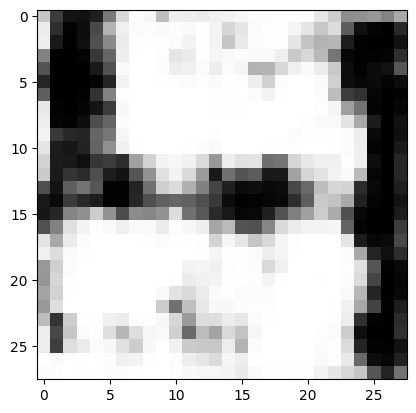

torch.Size([1, 1, 28, 28])


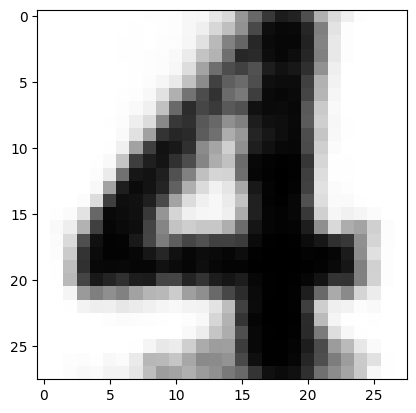

torch.Size([1, 1, 28, 28])


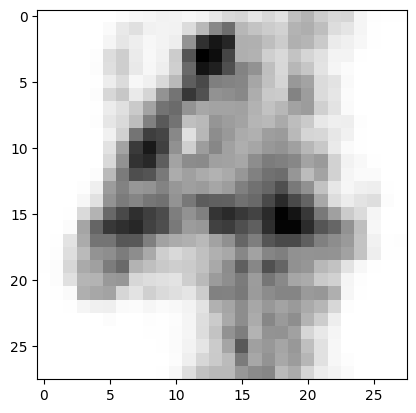

In [27]:
vae.eval()

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sort part of test set by digit
labels_res = [[] for _ in labels]
k = 0
c = 0
for img_batch_, label_batch_ in test_loader:
    for (img_batch, label_batch) in zip(img_batch_, label_batch_):
        if c == 1000:
            k = 0
            c = 0
        if k == 10:
            c += 1
            continue
        k += 1
        for i in range(img_batch.size(0)):
            l = one_hot_encode(label_batch)
#             print(label_batch, l)
            labels_res[l.type(torch.int32).numpy()[i]].append(img_batch[i:i+1])
        if sum(len(d) for d in labels_res) >= 10000:
            break

# print
# for i in labels_res:
#     print([k.shape for k in i])
#     print(len(i))
    

# print(labels[0].shape)
with torch.no_grad():
    for i in range(len(labels_res[0])):
        (img, _, _) = vae.forward(labels_res[0][i], '4')
        print(img.shape)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.show()
# interpolation lambdas
# lambda_range=np.linspace(0, 1, 10)

# fig, axs = plt.subplots(2,5, figsize=(15, 6))
# fig.subplots_adjust(hspace = .5, wspace=.001)
# axs = axs.ravel()

# print(labels_res[0][0].shape)

# for ind,l in enumerate(lambda_range):
#     inter_image=interpolation(float(l), vae, labels_res[0][0], labels_res[1][0])

#     inter_image = to_img(inter_image)

#     image = inter_image.numpy()

#     axs[ind].imshow(image[0,0,:,:], cmap='gray')
#     axs[ind].set_title('lambda_val='+str(round(l,1)))
# plt.show()

In [91]:
import os
for x in os.listdir("gwfonts/converted/train"):
    if(len(x.split("_")) > 1):
        print(x)

.DS_Store


In [90]:
# !rm -r gwfonts/converted/train/PT_Sans-Web-BoldItalic